# Exercise 01


## Exercise 01.1

### Exercise 01.1.1

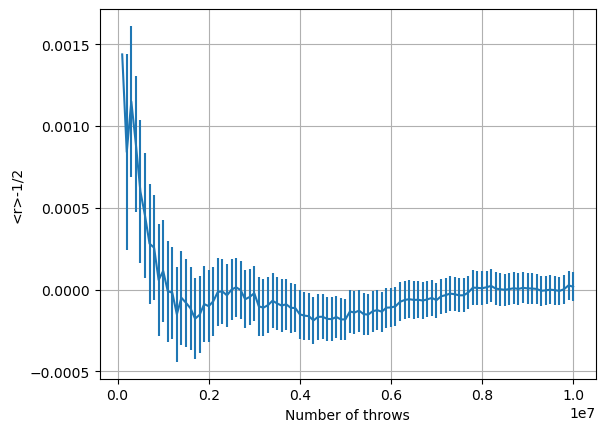

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

n_throws, cum_avg, block_error = np.loadtxt("../data/ex_01.1a.dat", unpack=True, usecols=(0,1,2))

plt.errorbar(n_throws, cum_avg-0.5, yerr=block_error)
plt.xlabel('Number of throws')
plt.ylabel('<r>-1/2')
plt.grid(True)
plt.show()

### Exercise 01.1.2

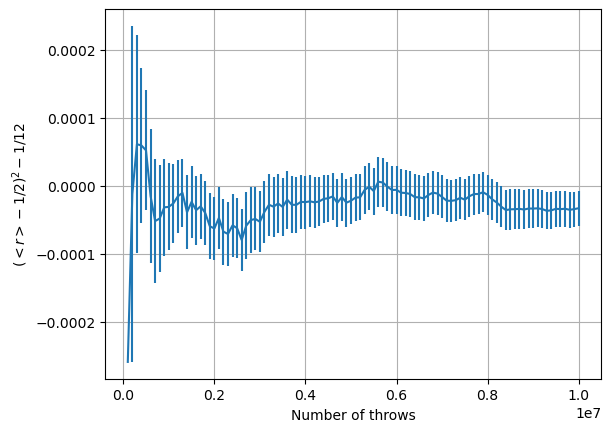

In [27]:
import math

vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex_01.1b.dat", unpack=True, usecols=(0,1,2))

plt.errorbar(vn_throws, vcum_avg-1/12, yerr=vblock_error)
plt.xlabel('Number of throws')
plt.ylabel("$(<r>-1/2)^2 - 1/12$")
plt.grid(True)
plt.show()

### Exercise 01.1.3

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_12941/447951139.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi^2$")


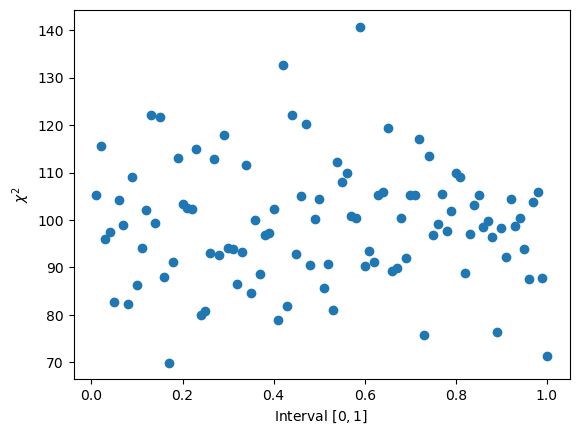

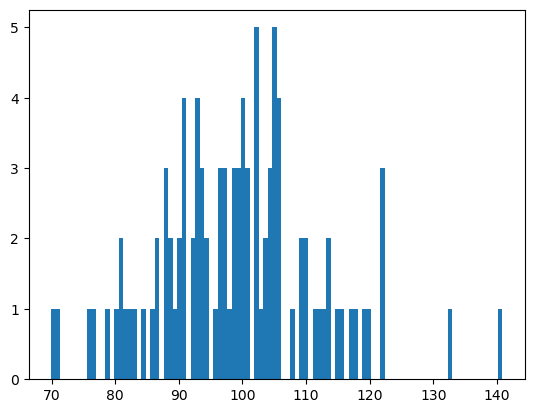

In [28]:
point, chi2 = np.loadtxt("../data/ex_01.1c.dat", unpack=True, usecols=(0,1))

plt.scatter(point*(1/100), chi2)
plt.xlabel("Interval $[0,1]$")
plt.ylabel("$\chi^2$")
plt.show()

plt.hist(chi2, 100)
plt.show()

## Exercise 01.2

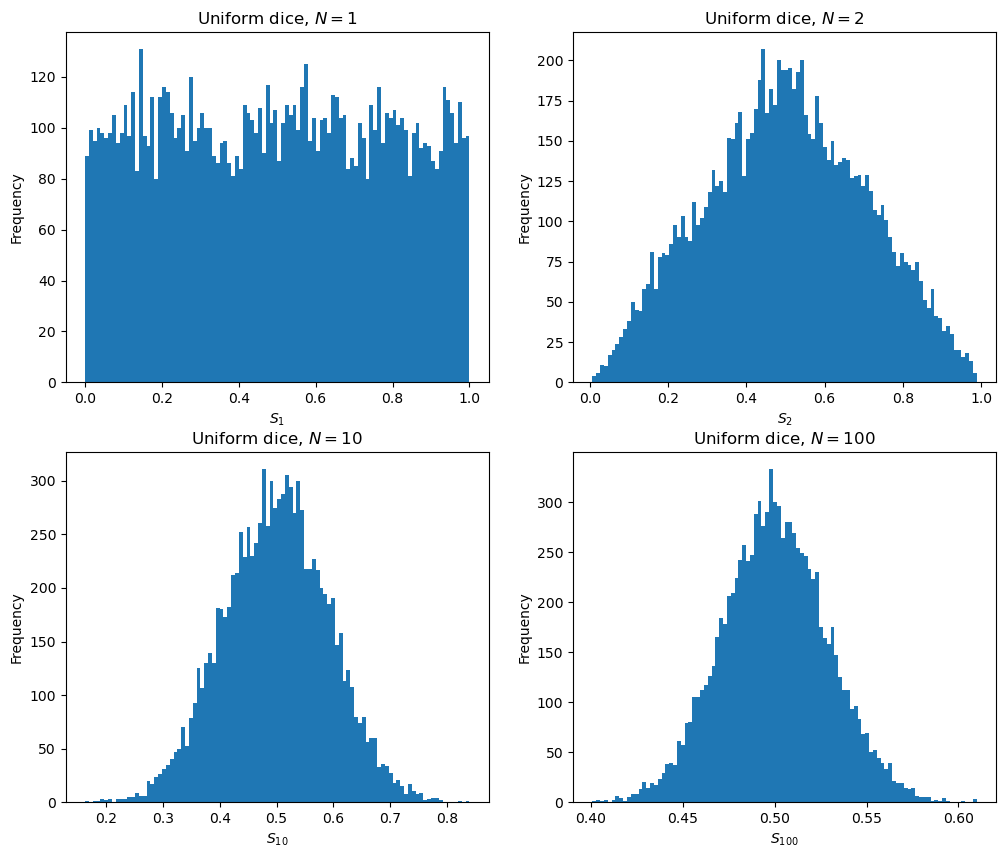

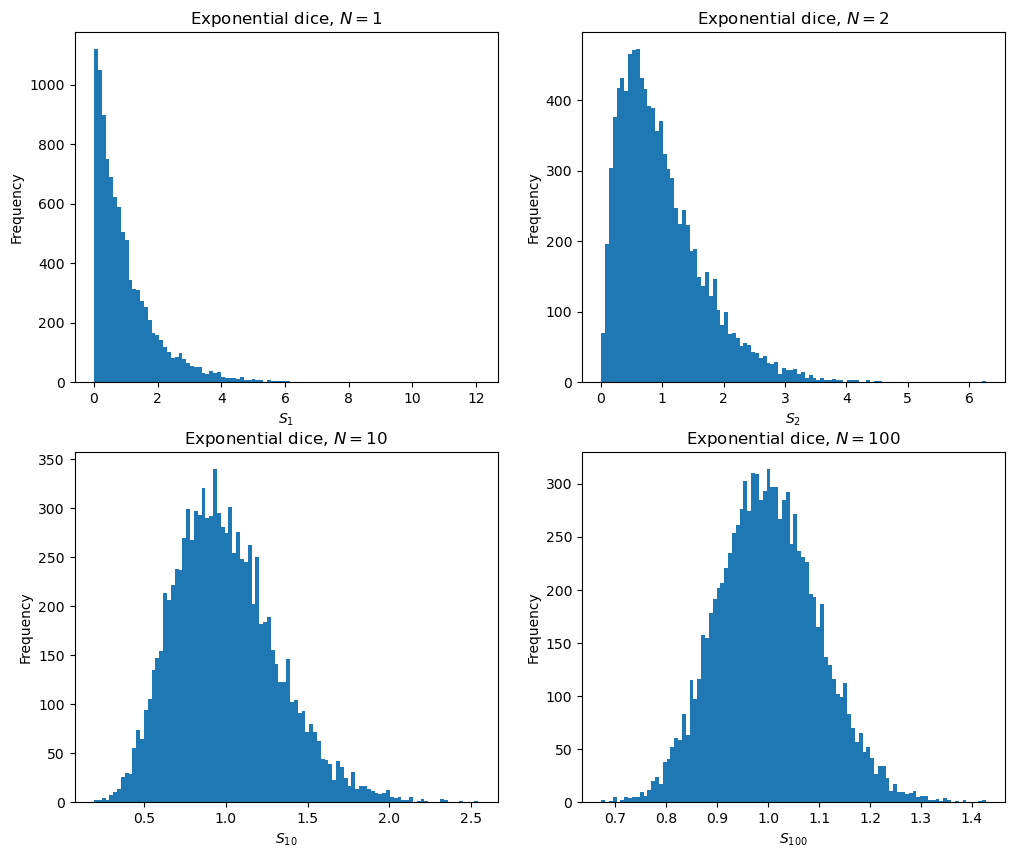

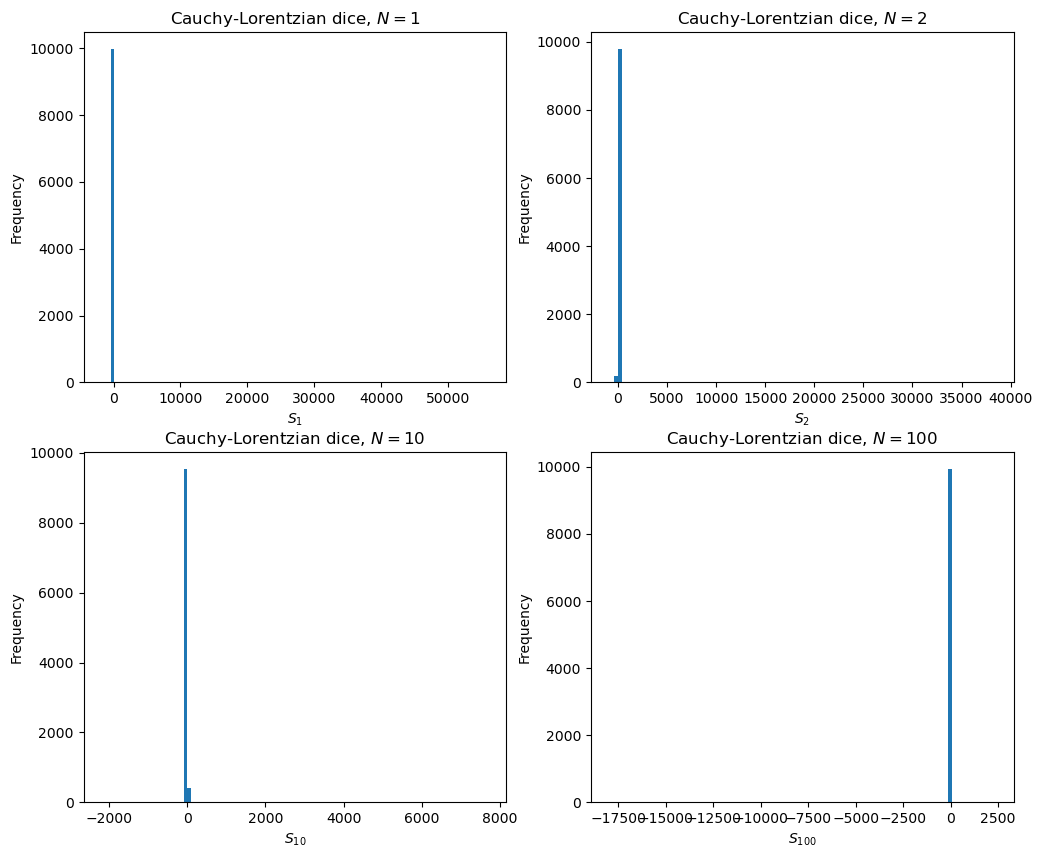

In [34]:
sumsize = [1, 2, 10, 100]    
name = [
    "Uniform dice",
    "Exponential dice",
    "Cauchy-Lorentzian dice"
]

unif_s1, expo_s1, cauchy_s1         = np.loadtxt("../data/ex_01.2s_1.dat", unpack=True, usecols=(0,1,2))
unif_s2, expo_s2, cauchy_s2         = np.loadtxt("../data/ex_01.2s_2.dat", unpack=True, usecols=(0,1,2))
unif_s10, expo_s10, cauchy_s10      = np.loadtxt("../data/ex_01.2s_10.dat", unpack=True, usecols=(0,1,2))
unif_s100, expo_s100, cauchy_s100   = np.loadtxt("../data/ex_01.2s_100.dat", unpack=True, usecols=(0,1,2))

unif = [unif_s1, unif_s2, unif_s10, unif_s100]

data = [
    [unif_s1, unif_s2, unif_s10, unif_s100],
    [expo_s1, expo_s2, expo_s10, expo_s100],
    [cauchy_s1, cauchy_s2, cauchy_s10, cauchy_s100]
]

n_bins = 100

for dist in range(3):
    plt.figure(figsize = (12,10))
    for sum in range(4):
        plt.subplot(2,2,sum+1)
        m = plt.hist(data[dist][sum], n_bins)
        plt.title("{name}, $N={size}$".format(name=name[dist], size=sumsize[sum]))
        plt.xlabel("$S_{%d}$" % sumsize[sum])
        plt.ylabel("Frequency")
    plt.show()
